# Can We Improve Results Using Covariance Feature Selection?

In [1]:
# Necessary libraries
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd

In [2]:
# Import data
data = pd.read_csv('KDDTrain+.txt')
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [3]:
# Remove Difficulty Level
data = data.drop('20', axis = 1)
data.head()

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,...,25,0.17.1,0.03,0.17.2,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal
0,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal
1,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune
2,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal
3,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal
4,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune


In [4]:
# Remove Categorical Features
data = data.drop(['tcp', 'ftp_data', 'SF'], axis = 1)

In [5]:
# Take Random Sample
data_sample = data.sample(59000)

In [6]:
data_sample.head()

,0,491,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,25,0.17.1,0.03,0.17.2,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal
57783,0,221,1161,0,0,0,0,0,1,0,...,255,1.00,0.00,1.00,0.06,0.0,0.0,0.0,0.0,normal
104803,0,294,8760,0,0,0,0,0,1,0,...,255,1.00,0.00,0.01,0.03,0.0,0.0,0.0,0.0,normal
71025,0,460,7055,0,0,0,0,0,1,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal
90287,9255,1,0,0,0,0,0,0,0,0,...,2,0.01,0.74,1.00,0.00,0.0,0.0,1.0,1.0,portsweep
17505,0,642,327,0,0,0,0,0,1,0,...,185,0.80,0.10,0.03,0.03,0.0,0.0,0.0,0.0,normal


In [7]:
# Separate source and target variables
y = data_sample[data_sample.columns[len(data_sample.columns)-1]]
print(y)
print(set(y))
print(y.shape)

57783        normal
104803       normal
71025        normal
90287     portsweep
17505        normal
            ...    
22039         satan
70605       neptune
4942      portsweep
116974       normal
29796        normal
Name: normal, Length: 59000, dtype: object
{'smurf', 'warezmaster', 'imap', 'land', 'spy', 'back', 'ftp_write', 'phf', 'perl', 'guess_passwd', 'warezclient', 'normal', 'teardrop', 'rootkit', 'loadmodule', 'portsweep', 'neptune', 'nmap', 'buffer_overflow', 'multihop', 'ipsweep', 'pod', 'satan'}
(59000,)


In [8]:
# Make target variables numerical
pd.set_option('mode.chained_assignment', None)
y.loc[y == 'normal'] = 1
y.loc[y != 1] = -1
y = np.int64(y)

In [9]:
print(set(y))
print(y.shape)

{1, -1}
(59000,)


In [10]:
og_data = data_sample.iloc[:,:-1]
print(og_data)

            0  491   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  150   25  \
57783       0  221  1161    0    0    0    0    0    1    0  ...    1  255   
104803      0  294  8760    0    0    0    0    0    1    0  ...   83  255   
71025       0  460  7055    0    0    0    0    0    1    0  ...  255  255   
90287    9255    1     0    0    0    0    0    0    0    0  ...  255    2   
17505       0  642   327    0    0    0    0    0    1    0  ...   30  185   
...       ...  ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
22039       0    1     0    0    0    0    0    0    0    0  ...  255    2   
70605       0    0     0    0    0    0    0    0    0    0  ...  255    4   
4942    21701    1     0    0    0    0    0    0    0    0  ...  255    2   
116974      0  238   296    0    0    0    0    0    1    0  ...   30  255   
29796       0  224   295    0    0    0    0    0    1    0  ...  109  255   

        0.17.1  0.03  0.17.2  0.00.6  0.00.7  0.00.8  0.05  0.0

In [11]:
X9 = data_sample.iloc[:,:-1]
X9.head()
print(X9.columns)

Index(['0', '491', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8',
       '0.9', '0.10', '0.11', '0.12', '0.13', '0.14', '0.15', '0.16', '0.17',
       '2', '2.1', '0.00', '0.00.1', '0.00.2', '0.00.3', '1.00', '0.00.4',
       '0.00.5', '150', '25', '0.17.1', '0.03', '0.17.2', '0.00.6', '0.00.7',
       '0.00.8', '0.05', '0.00.9'],
      dtype='object')


In [12]:
X8 = data_sample.iloc[:,:-1]
X8.head()

,0,491,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,150,25,0.17.1,0.03,0.17.2,0.00.6,0.00.7,0.00.8,0.05,0.00.9
57783,0,221,1161,0,0,0,0,0,1,0,...,1,255,1.00,0.00,1.00,0.06,0.0,0.0,0.0,0.0
104803,0,294,8760,0,0,0,0,0,1,0,...,83,255,1.00,0.00,0.01,0.03,0.0,0.0,0.0,0.0
71025,0,460,7055,0,0,0,0,0,1,0,...,255,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
90287,9255,1,0,0,0,0,0,0,0,0,...,255,2,0.01,0.74,1.00,0.00,0.0,0.0,1.0,1.0
17505,0,642,327,0,0,0,0,0,1,0,...,30,185,0.80,0.10,0.03,0.03,0.0,0.0,0.0,0.0


In [13]:
X7 = data_sample.iloc[:,:-1]

In [14]:
correlated_features_9 = set()
correlation_matrix_9 = X9.corr()

correlated_features_8 = set()
correlation_matrix_8 = X8.corr()

correlated_features_7 = set()
correlation_matrix_7 = X7.corr()

In [15]:
for i in range(len(correlation_matrix_9.columns)):
    for j in range(i):
        if abs(correlation_matrix_9.iloc[i,j])>.9:
            colname = correlation_matrix_9.columns[i]
            correlated_features_9.add(colname)

In [16]:
for i in range(len(correlation_matrix_8.columns)):
    for j in range(i):
        if abs(correlation_matrix_8.iloc[i,j])>.8:
            colname = correlation_matrix_8.columns[i]
            correlated_features_8.add(colname)

In [17]:
for i in range(len(correlation_matrix_7.columns)):
    for j in range(i):
        if abs(correlation_matrix_7.iloc[i,j])>.7:
            colname = correlation_matrix_7.columns[i]
            correlated_features_7.add(colname)

In [18]:
print(len(correlated_features_9))
print(len(correlated_features_8))
print(len(correlated_features_7))


7
9
11


In [19]:
X9.drop(labels = correlated_features_9, axis = 1, inplace = True)
X8.drop(labels = correlated_features_8, axis = 1, inplace = True)
X7.drop(labels = correlated_features_7, axis = 1, inplace = True)

In [20]:
# Original Data - 38 Features
recall_scores_lof = []
precision_scores_lof = []
f1_scores_lof = []
weighted_f1_scores_lof = []
false_alarms_lof = []


def lof_calculations(n):    
    
    lof = LocalOutlierFactor(n_neighbors = n)
    y_pred = lof.fit_predict(og_data)
    y_pred = np.array(y_pred)
    
    r = recall_score(y, y_pred, pos_label = -1)
    p = precision_score(y, y_pred, pos_label = -1)
    f = f1_score(y, y_pred, pos_label = -1)
    wf = f1_score(y, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    false_alarm = fp/(fp+tn)
   
    recall_scores_lof.append(r)
    precision_scores_lof.append(p)
    f1_scores_lof.append(f)
    weighted_f1_scores_lof.append(wf)
    false_alarms_lof.append(false_alarm)

In [21]:
# .9+ Threshold
recall_scores_lof2 = []
precision_scores_lof2 = []
f1_scores_lof2 = []
weighted_f1_scores_lof2 = []
false_alarms_lof2 = []


def lof_calculations2(n):    
    
    lof = LocalOutlierFactor(n_neighbors = n)
    y_pred = lof.fit_predict(X9)
    y_pred = np.array(y_pred)
    
    r = recall_score(y, y_pred, pos_label = -1)
    p = precision_score(y, y_pred, pos_label = -1)
    f = f1_score(y, y_pred, pos_label = -1)
    wf = f1_score(y, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    false_alarm = fp/(fp+tn)
   
    recall_scores_lof2.append(r)
    precision_scores_lof2.append(p)
    f1_scores_lof2.append(f)
    weighted_f1_scores_lof2.append(wf)
    false_alarms_lof2.append(false_alarm)

In [22]:
# .8+ Threshold
recall_scores_lof3 = []
precision_scores_lof3 = []
f1_scores_lof3 = []
weighted_f1_scores_lof3 = []
false_alarms_lof3 = []


def lof_calculations3(n):    
    
    lof = LocalOutlierFactor(n_neighbors = n)
    y_pred = lof.fit_predict(X8)
    y_pred = np.array(y_pred)
    
    r = recall_score(y, y_pred, pos_label = -1)
    p = precision_score(y, y_pred, pos_label = -1)
    f = f1_score(y, y_pred, pos_label = -1)
    wf = f1_score(y, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    false_alarm = fp/(fp+tn)
   
    recall_scores_lof3.append(r)
    precision_scores_lof3.append(p)
    f1_scores_lof3.append(f)
    weighted_f1_scores_lof3.append(wf)
    false_alarms_lof3.append(false_alarm)

In [23]:
# .7+ Threshold
recall_scores_lof4 = []
precision_scores_lof4 = []
f1_scores_lof4 = []
weighted_f1_scores_lof4 = []
false_alarms_lof4 = []


def lof_calculations4(n):    
    
    lof = LocalOutlierFactor(n_neighbors = n)
    y_pred = lof.fit_predict(X7)
    y_pred = np.array(y_pred)
    
    r = recall_score(y, y_pred, pos_label = -1)
    p = precision_score(y, y_pred, pos_label = -1)
    f = f1_score(y, y_pred, pos_label = -1)
    wf = f1_score(y, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    false_alarm = fp/(fp+tn)
   
    recall_scores_lof4.append(r)
    precision_scores_lof4.append(p)
    f1_scores_lof4.append(f)
    weighted_f1_scores_lof4.append(wf)
    false_alarms_lof4.append(false_alarm)

In [24]:
ilist = []

i = 5
while i <= 400:
    lof_calculations(i)
    lof_calculations2(i)
    lof_calculations3(i)
    lof_calculations4(i)
    ilist.append(i)
    i = i*2

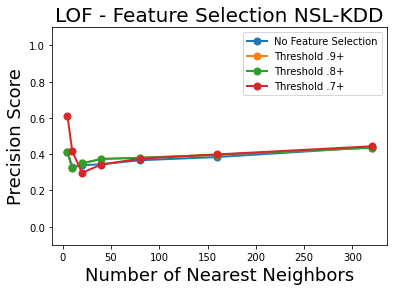

In [25]:
# plt.figure(figsize = (8,5))

plt.plot(ilist, precision_scores_lof, marker='o', linewidth=2, markersize=7, label='No Feature Selection')
plt.plot(ilist, precision_scores_lof2, marker='o', linewidth=2, markersize=7,label='Threshold .9+')
plt.plot(ilist, precision_scores_lof3, marker='o', linewidth=2, markersize=7, label='Threshold .8+')
plt.plot(ilist, precision_scores_lof4, marker='o', linewidth=2, markersize=7, label='Threshold .7+')

    
plt.xlabel('Number of Nearest Neighbors',fontsize = 18)
plt.ylabel('Precision Score',fontsize = 18)
plt.title('LOF - Feature Selection NSL-KDD', fontsize = 20)
    
leg = plt.legend();

plt.ylim((-.1, 1.1))

plt.show()

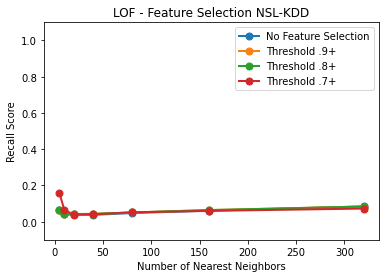

In [26]:
# plt.figure(figsize = (8,5))

plt.plot(ilist, recall_scores_lof, marker='o', linewidth=2, markersize=7, label='No Feature Selection')
plt.plot(ilist, recall_scores_lof2, marker='o', linewidth=2, markersize=7, label='Threshold .9+')
plt.plot(ilist, recall_scores_lof3, marker='o', linewidth=2, markersize=7, label='Threshold .8+')
plt.plot(ilist, recall_scores_lof4, marker='o', linewidth=2, markersize=7, label='Threshold .7+')

    
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Recall Score')
plt.title('LOF - Feature Selection NSL-KDD')
    
leg = plt.legend();

plt.ylim((-.1, 1.1))

plt.show()

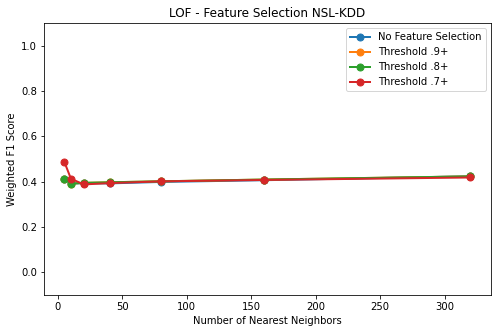

In [27]:
plt.figure(figsize = (8,5))

plt.plot(ilist, weighted_f1_scores_lof, marker='o', linewidth=2, markersize=7, label='No Feature Selection')
plt.plot(ilist, weighted_f1_scores_lof2, marker='o', linewidth=2, markersize=7, label='Threshold .9+')
plt.plot(ilist, weighted_f1_scores_lof3, marker='o', linewidth=2, markersize=7, label='Threshold .8+')
plt.plot(ilist, weighted_f1_scores_lof4, marker='o', linewidth=2, markersize=7, label='Threshold .7+')

    
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Weighted F1 Score')
plt.title('LOF - Feature Selection NSL-KDD')
    
leg = plt.legend();

plt.ylim((-.1, 1.1))

plt.show()

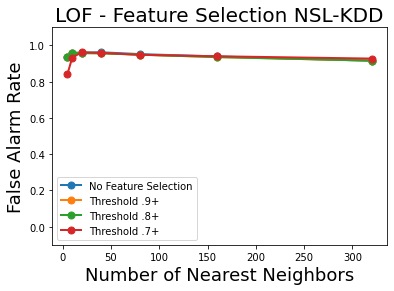

In [28]:
# plt.figure(figsize = (8,5))

plt.plot(ilist, false_alarms_lof, marker='o', linewidth=2, markersize=7, label='No Feature Selection')
plt.plot(ilist, false_alarms_lof2, marker='o', linewidth=2, markersize=7, label='Threshold .9+')
plt.plot(ilist, false_alarms_lof3, marker='o', linewidth=2, markersize=7, label='Threshold .8+')
plt.plot(ilist, false_alarms_lof4, marker='o', linewidth=2, markersize=7, label='Threshold .7+')

    
plt.xlabel('Number of Nearest Neighbors', fontsize = 18)
plt.ylabel('False Alarm Rate', fontsize = 18)
plt.title('LOF - Feature Selection NSL-KDD', fontsize = 20)
    
leg = plt.legend();

plt.ylim((-.1, 1.1))

plt.show()

In [29]:
# For single calculations

def single_calculation(n):
   
    lof = LocalOutlierFactor(n_neighbors = n)
    y_pred = lof.fit_predict(X7)
    y_pred = np.array(y_pred)
    
    p = precision_score(y, y_pred, pos_label = -1)
    r = recall_score(y, y_pred, pos_label = -1)
    f = f1_score(y, y_pred, pos_label = -1)
    wf = f1_score(y, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    false_alarm = fp/(fp+tn) 
    print('Value of Nearest Neighbor Parameter:', n)
    print('Precision:',p)
    print('Recall:',r)
    print('Weighted F1:',wf)
    print('False Alarm Rate:', false_alarm)

In [30]:
single_calculation(5)

Value of Nearest Neighbor Parameter: 5
Precision: 0.6122649452708392
Recall: 0.15861993746818875
Weighted F1: 0.4853894324430775
False Alarm Rate: 0.8413800625318112


In [31]:
single_calculation(4)

Value of Nearest Neighbor Parameter: 4
Precision: 0.6188187681800936
Recall: 0.17788846069948375
Weighted F1: 0.49698815156846216
False Alarm Rate: 0.8221115393005163


In [32]:
single_calculation(3)

Value of Nearest Neighbor Parameter: 3
Precision: 0.6045751633986928
Recall: 0.1950483530865993
Weighted F1: 0.5035481301676843
False Alarm Rate: 0.8049516469134007


In [33]:
print(max(precision_scores_lof4))
print(min(false_alarms_lof4))

0.6122649452708392
0.8413800625318112


In [34]:
ilist

[5, 10, 20, 40, 80, 160, 320]

In [ ]:
single_calculation